**Example of generating SHAP for the Employee Attrition Dataset**

This code is divdied into two segements: the first part is on training the model. The second is about generating SHAP (explanations)


**PART 1: Training your model (note that the Random Forest and Decision Tree classifiers need to be improved -- see the confusion matrix)**

In [ ]:
# My dataset is stored in my google drive. You can do the same or choose an alternative method

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install Ablibi and use their SHAP package to generated explanations. However, you can install SHAP as well to achieve the same outcome.

!pip install alibi[shap]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
import shap
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import random
from alibi.explainers import TreeShap
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from io import StringIO
import pydot
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
# In the next few steps, I load the dataset, preprocess it and the train a Decision Tree and Random Forest classifers. We then generate CF explanations for the RF classifier.


df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/EmployeeAttritionUpdated.csv")
attrition = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/EmployeeAttritionUpdated.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,OverTime,PercentSalaryHike,PerformanceRating,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,Yes,11,3,80,8,0,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,No,23,4,80,10,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,Yes,15,3,80,7,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,Yes,11,3,80,8,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,No,12,3,80,6,3,2,2,2,2


In [ ]:
# Define a dictionary for the target mapping
target_map = {'Yes': 1, 'No': 0}

# Use the pandas apply method to numerically encode our attrition target variable
attrition["Attrition_numerical"] = attrition["Attrition"].apply(lambda x: target_map[x])

# Drop the Attrition_numerical column from attrition dataset first - Don't want to include that
attrition = attrition.drop(['Attrition_numerical'], axis=1)

# Empty list to store columns with categorical data
categorical = []
for col, value in attrition.items():  # Use items() instead of iteritems()
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = attrition.columns.difference(categorical)

# Output the lists for verification
print("Categorical columns:", categorical)
print("Numerical columns:", numerical)


Categorical columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numerical columns: Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'StandardHours',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


In [ ]:
# Store the categorical data in a dataframe called attrition_cat
attrition_cat = attrition[categorical]
attrition_cat = attrition_cat.drop(['Attrition'], axis=1) # Dropping the target column

In [ ]:
attrition_cat = pd.get_dummies(attrition_cat)
attrition_cat.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,False,False,True,False,False,True,False,True,False,False,...,False,False,False,True,False,False,False,True,False,True
1,False,True,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,True,False,True,False
2,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


In [ ]:
# Scale numerical columns
scaler = StandardScaler()
attrition_num_scaled = pd.DataFrame(scaler.fit_transform(attrition[numerical]), columns=numerical)
# Store the numerical features to a dataframe attrition_num
attrition_num = attrition[numerical]
attrition_final = pd.concat([attrition_num, attrition_cat], axis=1)


In [ ]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = attrition["Attrition"].apply(lambda x: target_map[x])
target.head(3)

,Attrition
0,1
1,0
2,1


<Axes: xlabel='Attrition', ylabel='count'>

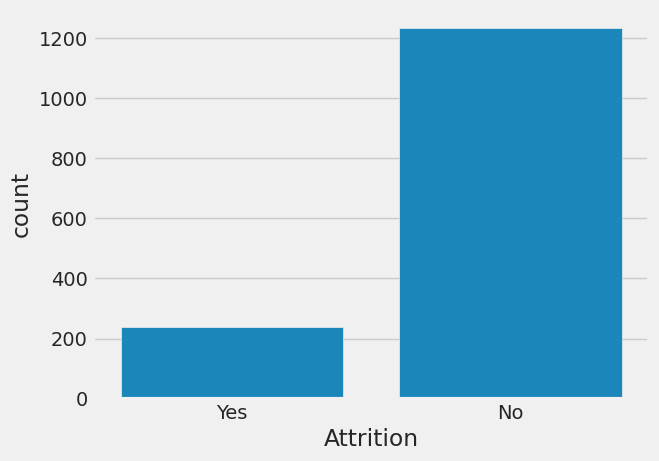

In [ ]:
sns.countplot(x='Attrition', data=attrition)


In [ ]:

# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_test = train_test_split(attrition_final,
                                                         target,
                                                         train_size= 0.80,
                                                         random_state=0);


# Perform oversampling on the training data
oversampler = SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_resample(train, target_train)

# Check the new class distribution
print("Class distribution after SMOTE:", Counter(smote_target))


Class distribution after SMOTE: Counter({0: 988, 1: 988})


In [ ]:


def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [ ]:
# NOTE THE PERFORMANCE IS TERRIBLE ON TEST --- PERFORM GRID SEARCH

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(smote_train, smote_target)

print_score(tree_clf, smote_train, smote_target, test, target_test, train=True)
print_score(tree_clf, smote_train, smote_target, test, target_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    988.0  988.0       1.0     1976.0        1976.0
_______________________________________________
Confusion Matrix: 
 [[988   0]
 [  0 988]]

Test Result:
Accuracy Score: 80.27%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.894515   0.421053  0.802721    0.657784      0.815604
recall       0.865306   0.489796  0.802721    0.677551      0.802721
f1-score     0.879668   0.452830  0.802721    0.666249      0.808528
support    245.000000  49.000000  0.802721  294.000000    294.000000
_______________________________________________
Conf

In [ ]:
X_train = smote_train
y_train = smote_target
X_test = test
y_test = target_test

Accuracy: 0.80
Confusion Matrix:
[[212  33]
 [ 25  24]]


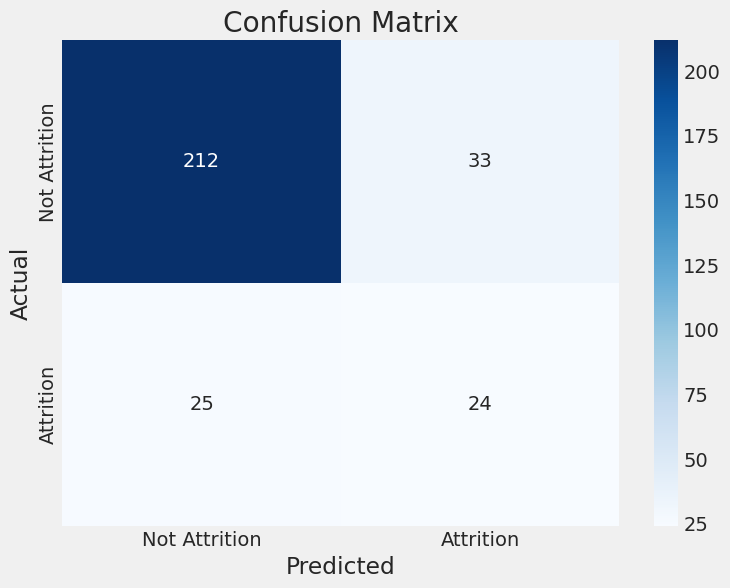

In [ ]:

class_names = ["Not Attrition", "Attrition"]

# Make predictions on the test set
test_predictions = tree_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Print and visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

# Save the model
joblib.dump(tree_clf, '/content/drive/MyDrive/Colab Notebooks/models/dt_attrition.joblib')
print("Saved DT model")

Saved DT model


In [ ]:
features = attrition_final.columns.tolist()

In [ ]:
class_names = ["Not Attrition", "Attrition"]
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data, feature_names=features, class_names=class_names ,filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

Output hidden; open in https://colab.research.google.com to view.

[0 1]


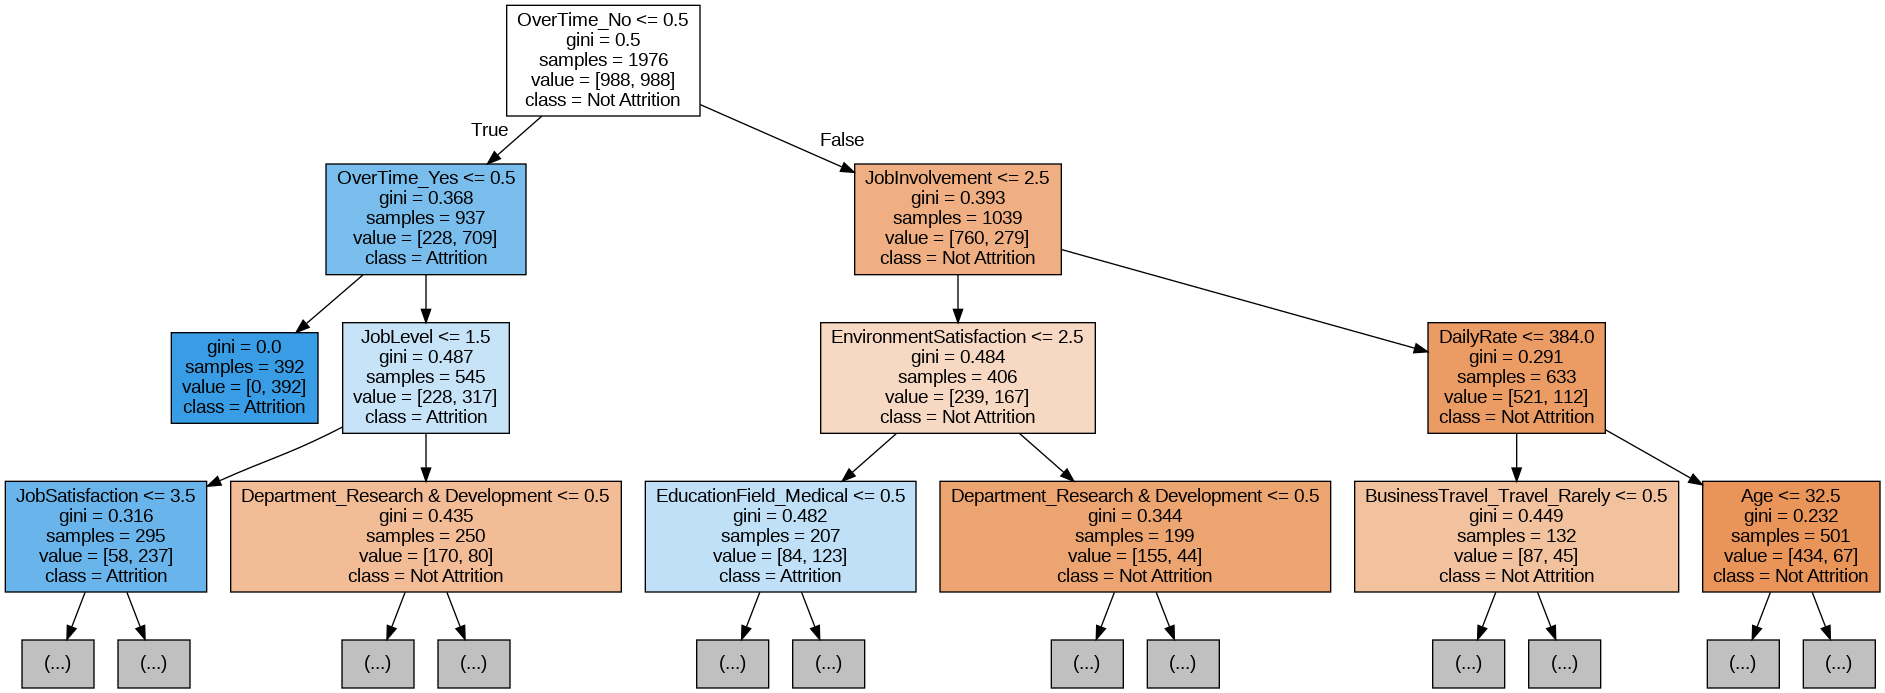

In [ ]:


print(tree_clf.classes_)

class_names = ["Not Attrition", "Attrition"]

# Control the depth of the tree in the visualization
dot_data = StringIO()
export_graphviz(
    tree_clf,
    out_file=dot_data,
    feature_names=features,
    filled=True,
    class_names=class_names,  # Add this to show class labels
    max_depth=3  # Adjust this value to control the depth
)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

In [ ]:


rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    988.0  988.0       1.0     1976.0        1976.0
_______________________________________________
Confusion Matrix: 
 [[988   0]
 [  0 988]]

Test Result:
Accuracy Score: 86.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.875458   0.714286  0.863946    0.794872      0.848596
recall       0.975510   0.306122  0.863946    0.640816      0.863946
f1-score     0.922780   0.428571  0.863946    0.675676      0.840412
support    245.000000  49.000000  0.863946  294.000000    294.000000
_______________________________________________
Conf

In [ ]:


# Save the best RF model
joblib.dump(rf_clf, '/content/drive/MyDrive/Colab Notebooks/models/rf_attrition.joblib')
print("Saved RF model")

Saved RF model


Accuracy: 0.86
Confusion Matrix:
[[239   6]
 [ 34  15]]


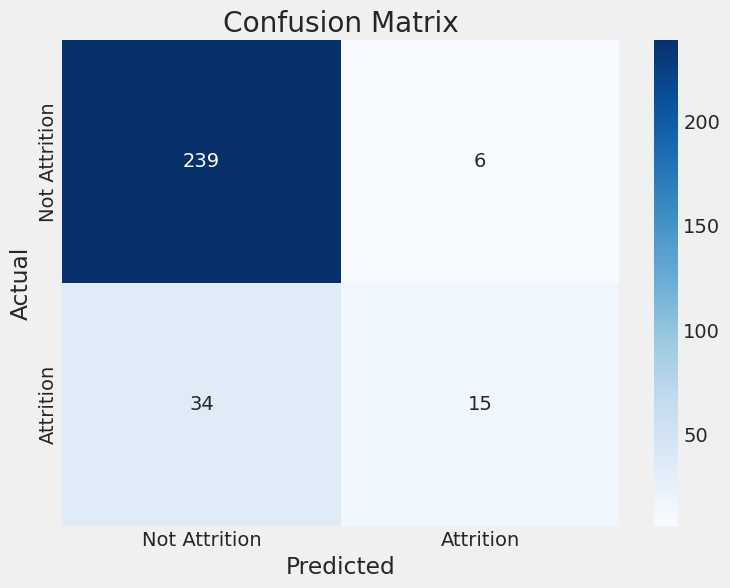

In [ ]:
# Make predictions on the test set
test_predictions = rf_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Print and visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})

print(X_train.dtypes)
print(X_test.dtypes)

Age                                  int64
DailyRate                            int64
DistanceFromHome                     int64
Education                            int64
EnvironmentSatisfaction              int64
HourlyRate                           int64
JobInvolvement                       int64
JobLevel                             int64
JobSatisfaction                      int64
MonthlyIncome                        int64
MonthlyRate                          int64
NumCompaniesWorked                   int64
PercentSalaryHike                    int64
PerformanceRating                    int64
StandardHours                        int64
TotalWorkingYears                    int64
TrainingTimesLastYear                int64
YearsAtCompany                       int64
YearsInCurrentRole                   int64
YearsSinceLastPromotion              int64
YearsWithCurrManager                 int64
BusinessTravel_Non-Travel            int64
BusinessTravel_Travel_Frequently     int64
BusinessTra

**PART 2: Explaining the model predictions using SHAP**

For detailed notes please refer to: https://docs.seldon.io/projects/alibi/en/latest/methods/TreeSHAP.html


In [ ]:


background_sample = X_train.sample(n=1000, random_state=42)

tree_explainer = TreeShap(
    predictor=rf_clf,
    model_output='raw',
    task='classification'
)
tree_explainer.fit(background_data=background_sample)



TreeShap(meta={
  'name': 'TreeShap',
  'type': ['whitebox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'model_output': 'raw',
              'summarise_background': False,
              'summarise_result': None,
              'approximate': None,
              'interactions': None,
              'explain_loss': None,
              'algorithm': 'interventional',
              'kwargs': {}}
            ,
  'version': '0.9.6'}
)

In [ ]:
explanation = tree_explainer.explain(X_test)

 94%|=================== | 554/588 [00:14<00:00]       

**Part 2(a): Global explanation**

See notes: https://docs.seldon.io/projects/alibi/en/latest/examples/interventional_tree_shap_adult_xgb.html

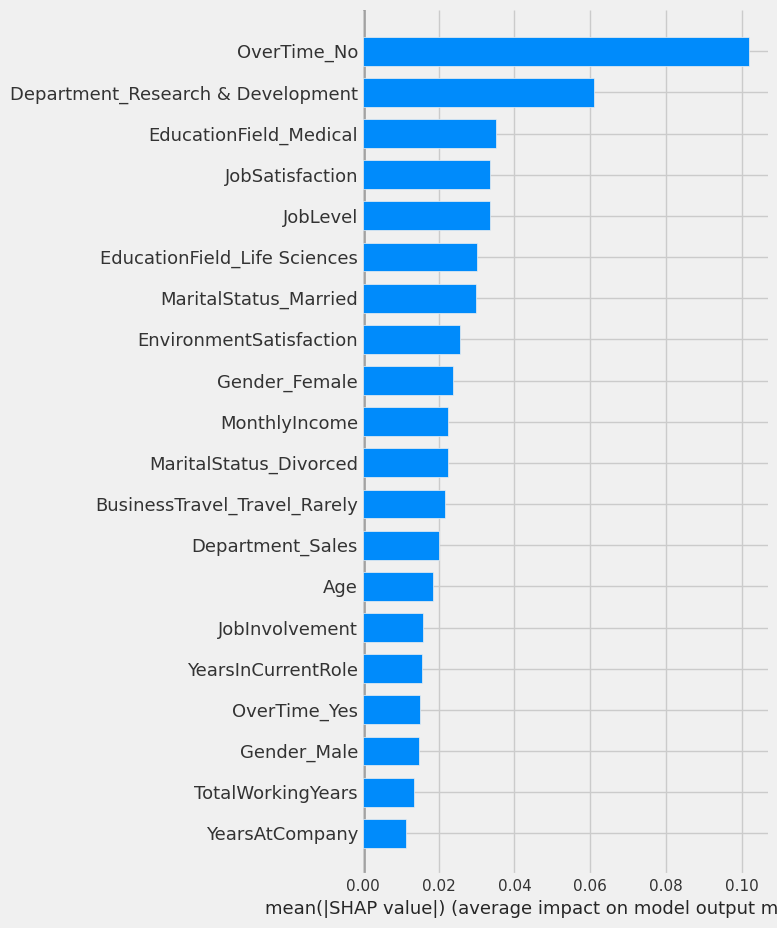

In [ ]:


shap.summary_plot(explanation.shap_values[0], X_test, feature_names, plot_type='bar')


**Explaining Single**

The following code selects a single instance from the dataset an explains it


instance_index: 118
Predicted class: 0
Predicted probabilities: [0.92 0.08]
Class index: 0
SHAP values: [ 1.50267846e-02  1.31263955e-03  4.78599929e-03 -7.53256861e-03
 -2.91118256e-02  5.64468416e-05  1.67407212e-02  4.56045773e-02
 -6.24380304e-03  4.97789626e-02  3.88725107e-03  8.20597682e-04
  7.13993509e-03 -5.59678922e-04  0.00000000e+00  2.26889716e-02
  1.12488744e-02  1.61294227e-02  8.47686885e-03  4.38983659e-03
 -2.16567809e-03 -1.21924961e-03 -3.71958897e-04  2.54423085e-02
 -5.74285715e-04  8.28999660e-02 -1.08521320e-02  0.00000000e+00
  4.92352543e-02 -1.98242064e-03 -1.30347073e-02 -4.57936508e-04
 -9.56666654e-04 -1.26798530e-02  1.84990645e-02  9.55983738e-04
 -1.75000002e-04  1.19359667e-03 -3.70952387e-04 -5.35079353e-04
  5.91381306e-03 -2.57543645e-03 -1.77856420e-03 -2.38650809e-04
  8.06144998e-02 -1.28528135e-02 -1.38451042e-03  1.00079930e-01
 -9.46853903e-03] 0.4557999953426788
Base value: 0.4642000000000005


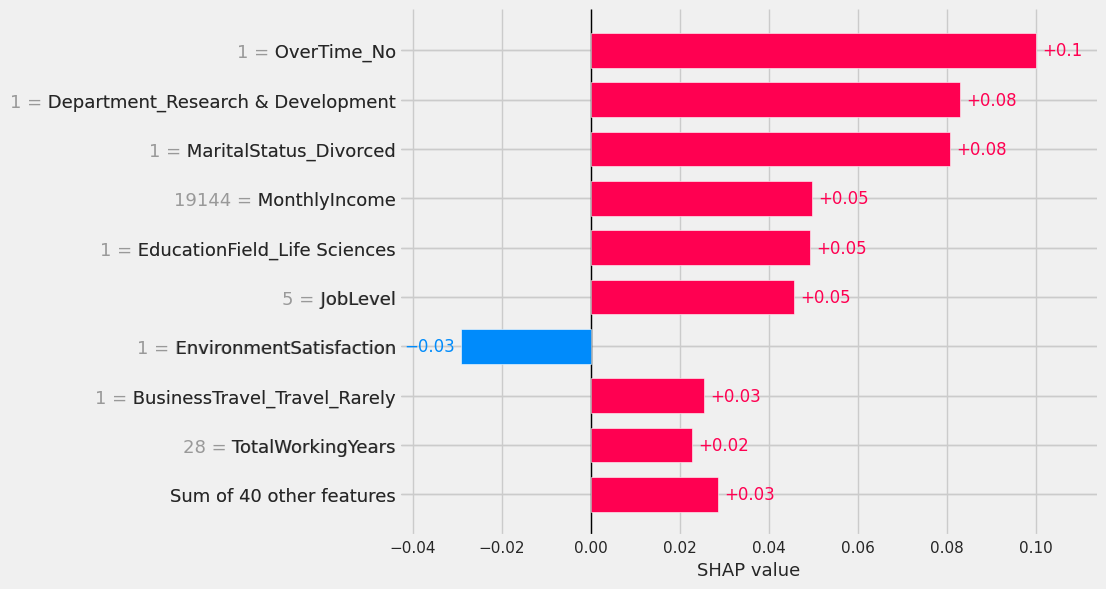

In [ ]:
# Explain the single instance

# choose a random record from X_test
instance_index = random.randint(0, X_test.shape[0] - 1)
single_instance = X_test.iloc[[instance_index]]

# Get the model's prediction for the single instance
prediction_class = rf_clf.predict(single_instance)[0]  # Predicted class
prediction_proba = rf_clf.predict_proba(single_instance)[0]  # Predicted probabilities

explanation = tree_explainer.explain(single_instance)

# get in index of the class with the higher prob using prediction_proba
class_index = np.argmax(prediction_proba)
shap_values = explanation.shap_values[class_index].reshape(-1)  # Flatten to 1D array
base_value = explanation.expected_value[class_index]  # Single base value

# Display the predictions
print("instance_index:", instance_index)
print("Predicted class:", prediction_class)
print("Predicted probabilities:", prediction_proba)
print("Class index:", class_index)
print("SHAP values:", shap_values, sum(shap_values))
print("Base value:", base_value)

# Create a SHAP explanation object
shap_values_single_instance = shap.Explanation(
    values=shap_values,
    base_values=base_value,
    data=single_instance.values[0],
    feature_names=X_test.columns
)

# Plot feature importance using shap.plots.bar
shap.plots.bar(shap_values_single_instance)
